In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
import wave
from scipy.signal import decimate, correlate
from os import listdir

In [2]:
data_path = './data-voices/'
files = [(data_path + file, file[-5]) for file in listdir(data_path)]
files.sort()

In [3]:
def fft(signal):
    n = len(signal)
    signal_fft = np.fft.fft(signal)
    signal_fft = np.abs(signal_fft)
    
    signal_fft = signal_fft * 2 / n
    signal_fft[0] = signal_fft[0] / 2
    return signal_fft
    

def signal_fft_audio(signal, sampling_rate = 44100):
    n = len(signal)
    if len(signal.shape) > 1:
        print('Incorrect signal shape')
        return
    
    fig = plt.figure(figsize = (16, 10))
    ax = fig.subplots(2, 1)
    time = np.linspace(0, n/sampling_rate, n, endpoint = False)
    ax[0].plot(time, signal)
    ax[0].set_xlabel('Czas [s]')
    ax[0].set_ylabel('Amplituda')
    
    signal_fft = fft(signal)
    
    frequencies = np.linspace(0, sampling_rate, n, endpoint = False)
    
    ax[1].plot(frequencies, signal_fft)
    ax[1].set_xlabel('Częstotliwość [Hz]')
    ax[1].set_ylabel('Amplituda')
    #ax[1].set_yscale('log')
    ax[1].set_xlim(0, 5000)
    
def read_wav_file(filepath):
    wave_read = wave.open(filepath, mode = 'rb')
    length = wave_read.getnframes()
    sample_rate = wave_read.getframerate()
    
    if wave_read.getsampwidth() == 1:
        type = np.uint8
    elif wave_read.getsampwidth() == 2:
        type = np.int16
    elif wave_read.getsampwidth() == 4:
        type = np.int32
    else:
        type = np.int16
        
    data = np.frombuffer(wave_read.readframes(length), count = wave_read.getnchannels() * length, dtype = type)
    if wave_read.getnchannels() >= 2:
        data = np.reshape(data, (length, wave_read.getnchannels()))
    wave_read.close()
    return sample_rate, data

In [4]:
def plot_spectrogram(signal, sample_rate = 44100, window = 4096, nshift = 256):
    fig = plt.figure(figsize = (16, 7))
    ax = fig.subplots()
    ax.specgram(signal, NFFT = window, Fs = sample_rate, noverlap = window - nshift,
                xextent = (0, len(signal)/sample_rate))

In [5]:
sample_rate, data = scipy.io.wavfile.read(files[10][0])

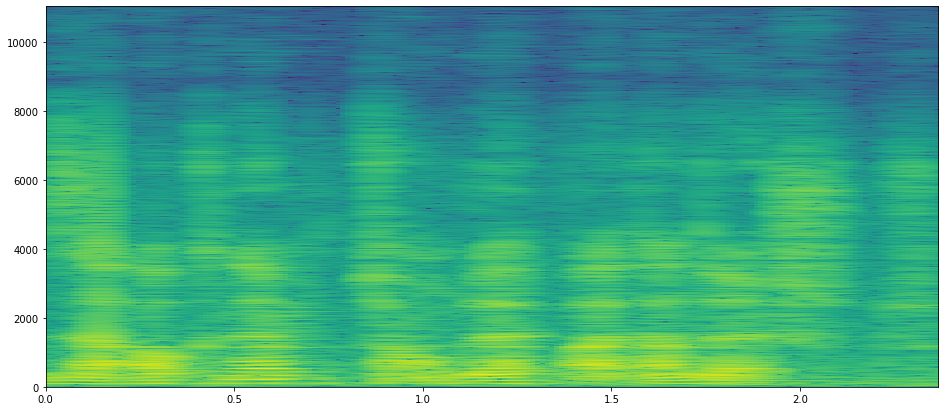

In [6]:
plot_spectrogram(data, sample_rate)

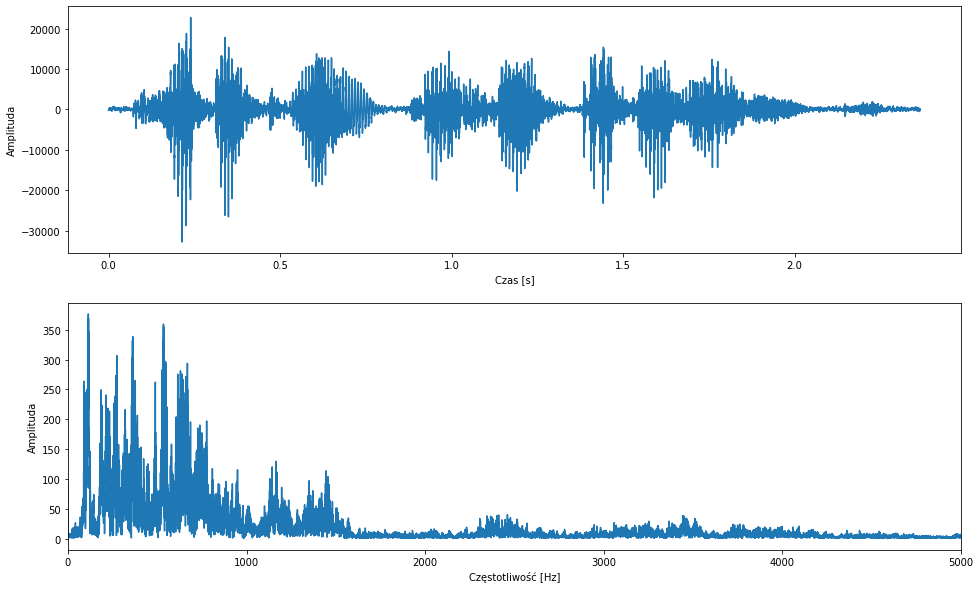

In [7]:
_ = signal_fft_audio(data, sample_rate)

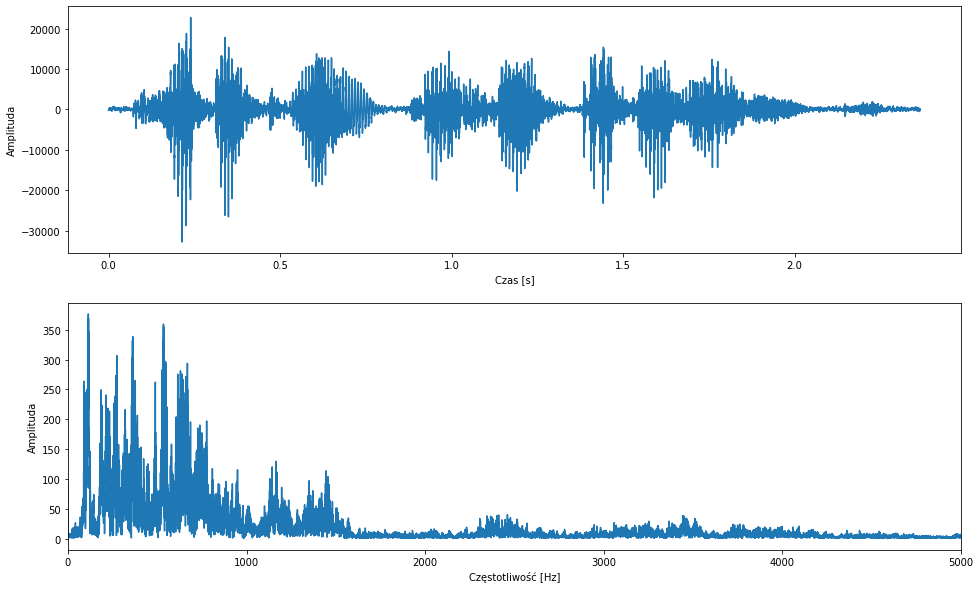

In [8]:
_ = signal_fft_audio(data, sample_rate)

In [12]:
def plot_hps(data, frequencies):
    fig = plt.figure(figsize = (16, 10))
    ax = fig.subplots()
    ax.plot(frequencies[:len(data)], data)
    #ax.set_yscale('log')
    plt.show()

#harmonic product spectrum
def hps(signal, sample_rate):
    n = len(signal)
    signal = fft(signal)
    
    
    n_harmonics = 4
    signal = signal[:len(signal)//2]
    result_signal = signal
    for i in range(2, n_harmonics + 1):
        downsampled = decimate(signal, i)
        result_signal = result_signal[:downsampled.shape[0]] * downsampled
    
    i_begin = int(60 * n / sample_rate)
    #frequencies = np.linspace(0, sample_rate, n, endpoint = False)
    #plot_hps(result_signal[i_begin:], frequencies[i_begin:])
    
    
    return (np.argmax(result_signal[i_begin:]) + i_begin) * sample_rate / n

In [60]:
def plot_ccorr(data, time):
    fig = plt.figure(figsize = (16, 10))
    ax = fig.subplots()
    ax.plot(time, data)
    #ax.set_yscale('log')
    plt.show()

#cross correlation
def cross_correlation(signal, sample_rate):
    #window_len = int(0.05 * sample_rate)
    #window = signal[len(signal)//2:len(signal)//2 + window_len]
    window_len = len(signal)
    window = signal
    window = window - np.mean(window)
    
    result = correlate(window, window, method = 'fft')
    
    high = sample_rate//300
    left = window_len - 1 + high
    right = window_len + sample_rate//60
    result = result[left:right]
    #time = [(high + i)/sample_rate for i in range(0, len(result))]
    #plot_ccorr(result, time)
    return sample_rate / (np.argmax(result) + high)

In [14]:
len(data)

52179

In [35]:
def classify_file(filepath):
    method = cross_correlation
    try:
        sample_rate, data = read_wav_file(filepath)
    except:
        return 'M'
    
    if len(data.shape) == 1:
        result = method(data, sample_rate)
        print(result)
    else:
        if data.shape[1] > 2:
            print(data.shape[1])
        result1 = method(data[:, 0], sample_rate)
        result2 = method(data[:, 1], sample_rate)
        print(result1, result2)
        result = (result1 + result2) / 2
    
    if result > 175:
        return 'K'
    else:
        return 'M'

In [16]:
def decision_tree_classification(filepath):
    try:
        w, signal=scipy.io.wavfile.read(filepath)
    except:
        return 'M'

    if(len(signal.shape)==2 and signal.shape[1]==2):
        signal = [s[0] for s in signal]
    signum=abs(np.fft.fft(signal))[:len(signal)//2]

    conn=(w/(len(signum)*2))
    d1=int(60//conn)
    d2=int(290//conn+1)

    dp=signum[d1:d2]*conn
    kv=sum(dp)
    asum=0

    p3=[0]*3
    for jj in range(len(dp)):
        asum+=dp[jj]
        for ij in range(1,4):
            if (asum>kv*ij*0.25 and p3[ij-1]==0):
                p3[ij-1]=jj*conn

    mode=(np.argmax(dp)+d1)*conn

    summa=0
    if (p3[0]<70):
        if (mode>207):
            cl='K'
        else:
            cl='M'

    elif (mode>=200):
        if (p3[0]<90):
            cl='M'
        else:
            cl='K'
    elif (p3[0]>95):
        cl='K'
    else:
        cl='M'
    return cl

In [17]:
def matrix_pretty_print(male_correct, male_wrong, female_wrong, female_correct):
    print('A\P   M  |  F')
    print('----------------')
    print('M   ', male_correct, ' | ', male_wrong, ' |')
    print('----------------')
    print('F   ', female_wrong, ' | ', female_correct, ' |')
    print('----------------')

In [61]:
# Male : 85 - 180 Hz
# Female : 165 - 255 Hz
female_correct, female_wrong = 0, 0
male_correct, male_wrong = 0, 0
for file, expected in files:
    result = classify_file(file)
    print(file, expected)
    
    if expected == result:
        print(result, 'OK')
        if expected == 'M':
            male_correct += 1
        else:
            female_correct += 1
    else:
        print(result, 'WRONG')
        if expected == 'M':
            male_wrong += 1
        else:
            female_wrong += 1
    
print((male_correct + female_correct) / (male_correct + male_wrong + female_wrong + female_correct))
matrix_pretty_print(male_correct, male_wrong, female_wrong, female_correct)

188.46153846153845 188.46153846153845
./data-voices/001_K.wav K
K OK
61.0803324099723 61.0803324099723
./data-voices/002_M.wav M
M OK
239.67391304347825
./data-voices/003_K.wav K
K OK
115.44502617801047
./data-voices/004_M.wav M
M OK
121.8232044198895
./data-voices/005_M.wav M
M OK
226.15384615384616
./data-voices/006_K.wav K
K OK
300.0
./data-voices/007_M.wav M
K WRONG
275.625 275.625
./data-voices/008_K.wav K
K OK
300.0 300.0
./data-voices/009_K.wav K
K OK
150.0 150.0
./data-voices/010_M.wav M
M OK
107.03883495145631
./data-voices/011_M.wav M
M OK
290.13157894736844
./data-voices/012_K.wav K
K OK
123.18435754189944
./data-voices/013_M.wav M
M OK
218.1818181818182 218.1818181818182
./data-voices/014_K.wav K
K OK
60.0 60.0
./data-voices/015_K.wav K
M WRONG
205.12820512820514
./data-voices/016_K.wav K
K OK
119.83695652173913 119.83695652173913
./data-voices/017_M.wav M
M OK
237.09677419354838
./data-voices/018_K.wav K
K OK
175.0
./data-voices/019_M.wav M
M OK
129.32551319648093 129.3255

In [32]:
# Male : 85 - 180 Hz
# Female : 165 - 255 Hz
female_correct, female_wrong = 0, 0
male_correct, male_wrong = 0, 0
for file, expected in files:
    result = classify_file(file)
    print(file, expected)
    
    if expected == result:
        print(result, 'OK')
        if expected == 'M':
            male_correct += 1
        else:
            female_correct += 1
    else:
        print(result, 'WRONG')
        if expected == 'M':
            male_wrong += 1
        else:
            female_wrong += 1
    
print((male_correct + female_correct) / (male_correct + male_wrong + female_wrong + female_correct))
matrix_pretty_print(male_correct, male_wrong, female_wrong, female_correct)

179.88505747126436 179.88505747126436
./data-voices/001_K.wav K
K OK
123.17355234547041 123.17355234547041
./data-voices/002_M.wav M
M OK
247.77297141640895
./data-voices/003_K.wav K
K OK
116.9271199549993
./data-voices/004_M.wav M
M OK
121.96997825279796
./data-voices/005_M.wav M
M OK
216.54934227639998
./data-voices/006_K.wav K
K OK
68.6188866422343
./data-voices/007_M.wav M
M OK
279.963092532294 279.963092532294
./data-voices/008_K.wav K
K OK
276.03390701258667 276.03390701258667
./data-voices/009_K.wav K
K OK
149.03731343283582 149.03731343283582
./data-voices/010_M.wav M
M OK
89.5877651928937
./data-voices/011_M.wav M
M OK
193.3407699491543
./data-voices/012_K.wav K
K OK
118.1918093475243
./data-voices/013_M.wav M
M OK
217.95678096148524 217.95678096148524
./data-voices/014_K.wav K
K OK
198.69791666666666 198.69791666666666
./data-voices/015_K.wav K
K OK
203.33333333333334
./data-voices/016_K.wav K
K OK
123.49026544593418 123.49026544593418
./data-voices/017_M.wav M
M OK
225.70754

In [22]:
print((male_correct + female_correct) / (male_correct + male_wrong + female_wrong + female_correct))
matrix_pretty_print(male_correct, male_wrong, female_wrong, female_correct)

0.8681318681318682
A\P   M  |  F
----------------
M    40  |  5  |
----------------
F    7  |  39  |
----------------


In [59]:
for filepath, _ in files[1:]:
    sample_rate1, data1 = read_wav_file(filepath)
    sample_rate2, data2 = scipy.io.wavfile.read(filepath)
    
    print(np.array_equal(data1, data2), sample_rate1 == sample_rate2)



True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True


/home/marcin/.local/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
